# Amazon Reviews Sentiment Analysis

This project performs sentiment analysis on the Amazon Reviews dataset. The goal is to build and evaluate machine learning models that can accurately classify reviews as positive or negative.

The process includes:
1.  **Loading Data**: Importing a large dataset of Amazon reviews.
2.  **Text Preprocessing**: Cleaning and preparing the text data for modeling.
3.  **Feature Extraction**: Converting text into numerical features.
4.  **Model Training**: Training multiple classification models.
5.  **Evaluation**: Assessing model performance to determine the most effective approach.**bold text**

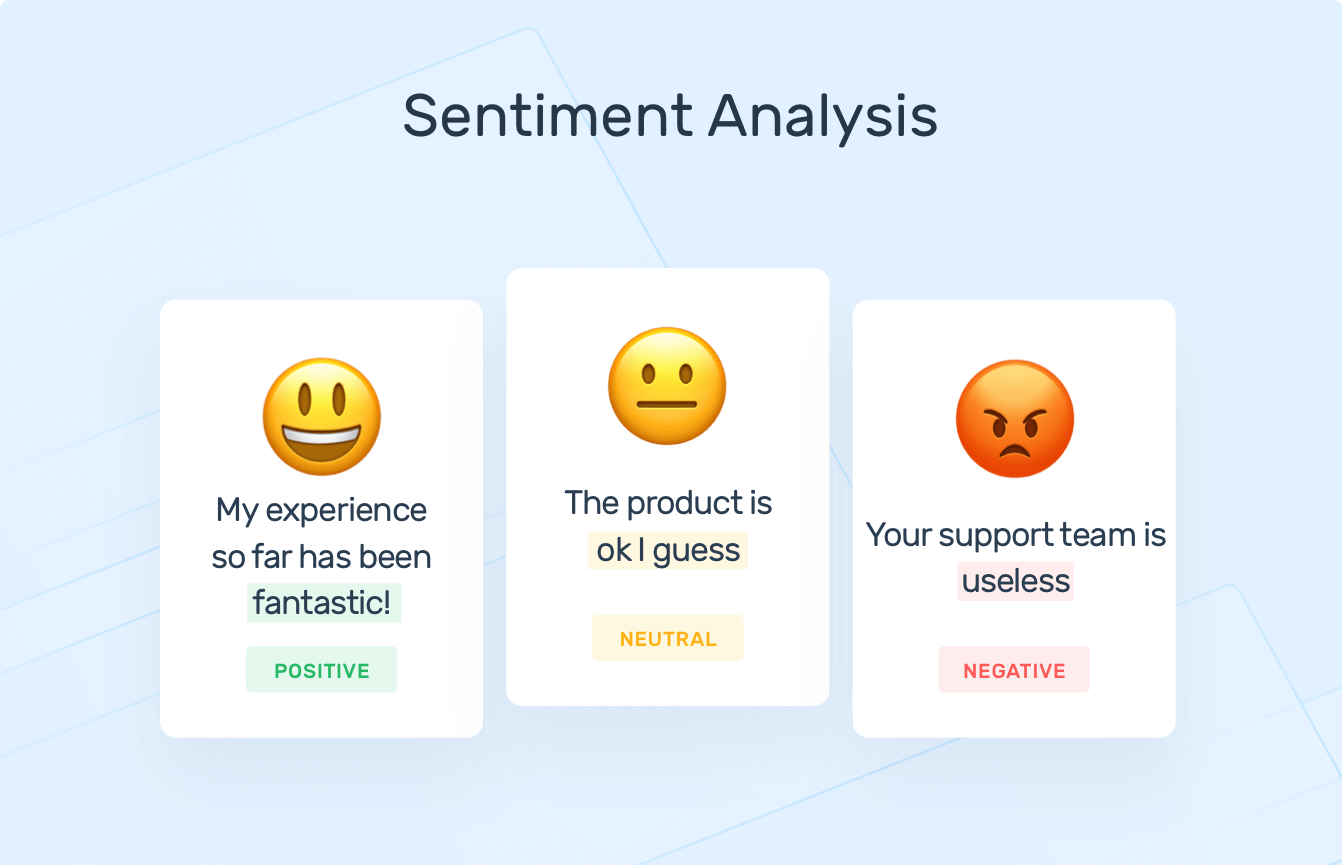

### 1. Importing Libraries

This cell imports all the necessary libraries for data manipulation, natural language processing (NLP), and machine learning. This includes `pandas` for data handling, `nltk` for text processing, and `sklearn` for building and evaluating models.

In [1]:
import bz2
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm
import shutil
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Loading and Combining the Dataset

The dataset is distributed in compressed `.bz2` files. This section defines a function to load the data from these files into a pandas DataFrame. The training and test datasets are loaded separately and then concatenated into a single DataFrame for unified preprocessing. Each review is labeled as `1` (negative) or `2` (positive).

In [ ]:
paths = [
    '/content/drive/MyDrive/amazonreviews/train.ft.txt.bz2',
    '/content/drive/MyDrive/amazonreviews/test.ft.txt.bz2'
]
def load_bz2_to_df(path):
    with bz2.open(path, 'rt', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    texts, labels = [], []
    for line in lines:
        parts = line.split(' ', 1)
        if len(parts) == 2:
            label = parts[0].replace('__label__', '')
            text = parts[1]
            labels.append(label)
            texts.append(text)
    return pd.DataFrame({'text': texts, 'label': labels})
train_df = load_bz2_to_df(paths[0])
test_df = load_bz2_to_df(paths[1])
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.head())
print(df['label'].value_counts())

                                                text label
0  Stuning even for the non-gamer: This sound tra...     2
1  The best soundtrack ever to anything.: I'm rea...     2
2  Amazing!: This soundtrack is my favorite music...     2
3  Excellent Soundtrack: I truly like this soundt...     2
4  Remember, Pull Your Jaw Off The Floor After He...     2
label
2    2000000
1    2000000
Name: count, dtype: int64


### 3. Initial Text Preprocessing

This section focuses on cleaning the raw review text. The `clean_text` function performs three key steps:
1.  **Lowercasing**: Converts all text to lowercase to ensure uniformity.
2.  **Stopword Removal**: Removes common English words (e.g., 'the', 'a', 'is') that don't carry significant meaning for sentiment analysis.
3.  **Stemming**: Reduces words to their root form (e.g., 'running' becomes 'run') using the Snowball stemmer. This helps group related words.

These operations are applied to every review in the dataset.

In [ ]:
def clean_text(text,stop_words,stemmer):
  words=text.lower().split()
  words=[word for word in words if word not in stop_words]
  words=[stemmer.stem(word)for word in words]
  return ' '.join(words)

In [ ]:
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
cleaned_documents=[clean_text(doc,stop_words=stop_words,stemmer=stemmer)for doc in tqdm(df['text'])]

100%|██████████| 4000000/4000000 [41:11<00:00, 1618.23it/s]


### 4. Saving and Caching Processed Data

Since text preprocessing on a large dataset is time-consuming, the cleaned data is saved to a CSV file. This allows us to reload the processed data directly in future sessions, skipping the previous cleaning steps and saving significant time.

In [ ]:
cleaned_df=pd.DataFrame({'documents':cleaned_documents,'label':list(df['label'])})

In [ ]:
cleaned_df.to_csv('cleaned documents.csv',index=False)

In [ ]:
shutil.copy('/content/cleaned documents.csv', '/content/drive/MyDrive/amazonreviews')

'/content/drive/MyDrive/amazonreviews/cleaned documents.csv'

### 5. Final Data Cleaning

This section performs additional cleaning on the preprocessed text. The functions here are designed to:
- **Remove URLs**: Strips web links from the text.
- **Remove Symbols**: Eliminates special characters, punctuation, and mentions (e.g., `@`, `#`) that do not contribute to sentiment.

These steps ensure the text is free of noise before feature extraction.

In [2]:
cleaned_data=pd.read_csv('/content/drive/MyDrive/amazonreviews/cleaned documents.csv')

In [3]:
def remove_URL(doc):
  return re.sub(r'(?:https://|http://|www\.)[^\s,]+', '', doc)

In [4]:
def remove_symbols(doc):
    doc = re.sub(r'[@#]\w+', '', doc)
    doc = re.sub(r'[^\w\s]', '', doc)
    return doc


In [5]:
def clean_data_from_impurities(doc):
  doc=remove_URL(doc)
  doc=remove_symbols(doc)
  return doc

In [6]:
cleaned_data['documents']=cleaned_data['documents'].apply(lambda x: clean_data_from_impurities(x))

### 6. Displaying the Final Cleaned Data

After all cleaning steps, we display the first few rows of the final DataFrame to verify that the text has been successfully processed and is ready for the next stages.

In [7]:
cleaned_data

,documents,label
0,stune even nongamer sound track beautiful pain...,2
1,best soundtrack ever anything read lot review ...,2
2,amazing soundtrack favorit music time hand dow...,2
3,excel soundtrack truli like soundtrack enjoy v...,2
4,remember pull jaw floor hear it play game know...,2
...,...,...
3999995,unbelievable bad way bought thoma son huge tho...,1
3999996,almost great broke son reciev birthday gift 2 ...,1
3999997,disappoint bought toy son love thomas toys ne...,1
3999998,classic jessica mitford compil wide rang mitfo...,2


### 7. Splitting Data and Building Vocabulary

The cleaned dataset is split into features (`X`) and labels (`y`). We then use `train_test_split` to create training and testing sets, allocating 90% of the data for training and 10% for testing. Finally, a vocabulary is built by collecting all unique words from the training set to understand the size and complexity of the text data.

In [8]:
X=cleaned_data['documents']
y=cleaned_data['label']

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,shuffle=True,random_state=42)

In [10]:
print(f'X Train shape : {X_train.shape}')
print(f'y Train shape : {y_train.shape}')
print(f'X Test shape : {X_test.shape}')
print(f'y Test shape : {y_test.shape}')

X Train shape : (3600000,)
y Train shape : (3600000,)
X Test shape : (400000,)
y Test shape : (400000,)


In [11]:
vocab=set()
for sentence in X_train:
  words=sentence.lower().split()
  for word in words:
    vocab.add(word)

In [12]:
len(vocab)

2211271

### 8. Feature Extraction using HashingVectorizer

Machine learning models require numerical input. `HashingVectorizer` is used here to convert the text documents into a numerical matrix. It uses a hashing trick to map words (unigrams and bigrams) to a fixed number of features (`n_features`). This method is memory-efficient and scalable for large datasets, though it can sometimes lead to hash collisions.

In [13]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=30000, ngram_range=(1,2), alternate_sign=False)
train_data = vectorizer.transform(X_train)
test_data = vectorizer.transform(X_test)


### 9. Model Training and Evaluation: Logistic Regression

A `LogisticRegression` model is trained on the vectorized training data. The `C` hyperparameter is set to `5.0` to control the regularization strength. After training, the model's performance is evaluated on the test set. The accuracy and a detailed classification report (including precision, recall, and F1-score) are printed to assess its effectiveness.

In [22]:
LR_model = LogisticRegression(C=5.0,max_iter=1000, multi_class='multinomial', solver='lbfgs')
LR_model.fit(train_data, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=5.0, max_iter=1000, multi_class='multinomial')

In [23]:
y_pred = LR_model.predict(test_data)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8804775
Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.88      0.88    200047
           2       0.88      0.88      0.88    199953

    accuracy                           0.88    400000
   macro avg       0.88      0.88      0.88    400000
weighted avg       0.88      0.88      0.88    400000



### 10. Model Training and Evaluation: Linear SVC

To compare performance, a second model, `LinearSVC` (Linear Support Vector Classifier), is trained. `LinearSVC` is often highly effective for text classification tasks and can be faster than `LogisticRegression`. After training, its accuracy on the test set is calculated and printed to compare its performance against the first model.

In [25]:
from sklearn.svm import LinearSVC
L_SVCmodel = LinearSVC(max_iter=1000)
L_SVCmodel.fit(train_data, y_train)

LinearSVC()

In [26]:
y_pred = L_SVCmodel.predict(test_data)

In [27]:
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8799525


### 11. Conclusion

This notebook successfully built and evaluated two different models for sentiment analysis. The results show that both `LogisticRegression` and `LinearSVC` achieve high accuracy (around 88%) on this large-scale dataset. The `LogisticRegression` model performed slightly better in this configuration.

**Future Improvements:**
- **Use `TfidfVectorizer`**: This could improve accuracy by weighting words by their importance.
- **Hyperparameter Tuning**: A more systematic search (e.g., `GridSearchCV`) could find optimal parameters for either model.
- **Advanced Models**: Exploring deep learning models like LSTMs or Transformers could yield even better results.